__Remember__: 
 * Everything takes longer than expected
 * Break into separate notebooks when analysis gets long enough

# Setup

In [14]:
raw_df.columns

Index(['Timestamp of Report (GMT)', 'Latitude', 'Longitude', 'Weather',
       'Number of Photos Added', 'Ambient Audio (dB)',
       'Ambient Audio Description', 'Number of Steps',
       'What did you learn today?', 'Who are you with?',
       'How many coffees did you have today?', 'Are you working?',
       'How did you sleep?', 'Where are you?', 'What are you doing?',
       'outcome', 'Choose intervention '],
      dtype='object')

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import scipy.stats

raw_df = pd.read_csv('data/reporter20180704.csv', 
                     parse_dates=['Timestamp of Report (Local Time)']
                    ).rename(columns={'Timestamp of Report (Local Time)':'ts', 'Choose intervention ':'intervention', 'How does your stomach feel?':'outcome'}
                    ).set_index('ts')
raw_df['outcome'] = raw_df['outcome'].apply(lambda x: x.strip() if pd.notnull(x) else '')
df = raw_df[['intervention', 'outcome']].copy()
df.tail()

intervention      outcome
ts                                                
2018-07-04 16:33:38               NaN  Distracting
2018-07-04 16:43:20  Tummy Drop (1ct)   Noticeable
2018-07-04 17:26:52               NaN  Distracting
2018-07-04 18:18:02               NaN   Noticeable
2018-07-04 18:43:48  Tummy Drop (1ct)  Distracting

# Analysis Template

In [54]:
df[(1==1) & (df.outcome == outcome)]

intervention      outcome
ts                                                
2018-07-04 16:22:00               NaN  Distracting
2018-07-04 16:23:35               NaN  Distracting
2018-07-04 16:33:38               NaN  Distracting
2018-07-04 17:26:52               NaN  Distracting
2018-07-04 18:43:48  Tummy Drop (1ct)  Distracting

In [61]:
intervention = "Tummy Drop (1ct)"
outcome_list = [x for x in df.outcome.unique().tolist() if len(x)]
prepost_intervention = pd.DataFrame(columns=pd.MultiIndex.from_product([['pre', 'post'], outcome_list]))
for ix in df[df.intervention == intervention].index:
    for arm, outcome in prepost_intervention.columns:
        if arm == 'pre':
            prepost_intervention.loc[ix, (arm, outcome)] = df[  (1==1)
                                              & (df.index > ix - pd.Timedelta(1, 'h'))
                                              & (df.index <= ix)
                                              & (df.outcome == outcome)
                                             ].index.size
        elif arm == 'post':
            prepost_intervention.loc[ix, (arm, outcome)] = df[  (1==1)
                                              & (df.index > ix)
                                              & (df.index <= ix + pd.Timedelta(1, 'h'))
                                              & (df.outcome == outcome)
                                             ].index.size
        else:
            raise ValueError('arm should only be pre or post')
    
prepost_intervention

pre                   post           
                    Distracting Noticeable Distracting Noticeable
2018-07-04 16:43:20         3.0        1.0         1.0        0.0
2018-07-04 18:43:48         1.0        1.0         0.0        0.0

In [70]:
confusion_matrix = prepost_intervention.sum(axis=0).unstack()
print(confusion_matrix)
oddsratio, pvalue = scipy.stats.fisher_exact(confusion_matrix.values)
print('p-value of no effect: {:0.2f}'.format(pvalue))

      Distracting  Noticeable
post          1.0         0.0
pre           4.0         2.0
p-value of no effect: 1.00


In [75]:
# TODO Bayesian comparison of credible intervals for proportion of each in the pre and post
# https://www.safaribooksonline.com/library/view/bayesian-methods-for/9780133902914/ch07.html
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

# PUT RESULTS HERE
distractingcnt_pre = 10
nondistractingcnt_pre = 10
distractingcnt_post = 10
nondistractingcnt_post = 10

posterior_pre = beta(alpha_prior + distractingcnt_pre,
                    beta_prior + nondistractingcnt_pre)

posterior_post = beta(alpha_prior + distractingcnt_post,
                    beta_prior + nondistractingcnt_post)

samples = 20000 # We want this to be large to get a better approximation.
samples_posterior_pre = posterior_pre.rvs(samples)
samples_posterior_post = posterior_post.rvs(samples)

print("Probability that portion 'distracting' in post is less than pre: {:0.2f}".format((samples_posterior_post < samples_posterior_pre).mean()))

Probability that portion 'distracting' in post is less than pre: 0.97


# Simulation of data collection

In [78]:
# TODO Bayesian comparison of credible intervals for proportion of each in the pre and post
# https://www.safaribooksonline.com/library/view/bayesian-methods-for/9780133902914/ch07.html
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

# 3 experiments per day for 7 days a week for 2 weeks
distractingcnt_pre = 10
nondistractingcnt_pre = 10
distractingcnt_post = 5
nondistractingcnt_post = 17
print("Total samples: {:0.0f}".format(distractingcnt_pre+nondistractingcnt_pre+distractingcnt_post+nondistractingcnt_post))

posterior_pre = beta(alpha_prior + distractingcnt_pre,
                    beta_prior + nondistractingcnt_pre)

posterior_post = beta(alpha_prior + distractingcnt_post,
                    beta_prior + nondistractingcnt_post)

samples = 20000 # We want this to be large to get a better approximation.
samples_posterior_pre = posterior_pre.rvs(samples)
samples_posterior_post = posterior_post.rvs(samples)

print("Probability that portion 'distracting' in post is less than pre: {:0.2f}".format((samples_posterior_post < samples_posterior_pre).mean()))

Total samples: 42
Probability that portion 'distracting' in post is less than pre: 0.96


# Matt, The Game

## MTGv01

* hypothesized model
* hypothesized parameters
* test meal sequence
    * Pandas DF: Rows are datetime in hours, columns are macronutrients
* visible state
    * Pandas DF: Rows are datetime in hours, columns are readings if taken in that hour
* hidden state
    * Pandas DF: Rows are datetime in hours, columns are hidden state
    
You could imagine doing some genetic search to find the parameters that fit the observed meal sequence and visible output

In [123]:
def hidden_to_visible(hidden):
    """Map hidden states to visible ones"""
    if hidden < 1:
        return 'great'
    elif hidden < 2:
        return 'fine'
    else:
        return 'bad'

def model01(params_and_state, hidden_to_visible):
    """Take static parameters and state, return that hour's state"""
    hidden_state = (
        params_and_state.get('meal_sequence', pd.DataFrame())
        .rolling(params_and_state.get('fat_effect_hours', 1), min_periods=0).sum()
        .rename(columns={'fat': 'fatness'}))
    
    visible_state = hidden_state.applymap(hidden_to_visible).rename(columns={'fatness': 'report'})
    
    return hidden_state, visible_state

def model02(params_and_state, hidden_to_visible):
    """Take static parameters and state, return that hour's state"""
    meal_sequence = params_and_state.get('meal_sequence', pd.DataFrame())
    latest_ix = meal_sequence.index[-1]
    window_start_ix = latest_ix - pd.Timedelta(params_and_state.get('fat_effect_hours', 1), 'h')
    hidden_state = (
        meal_sequence.loc[window_start_ix: latest_ix].sum().fillna(0)
        .rename(index={'fat': 'fatness'}))
    
    visible_state = hidden_state.apply(hidden_to_visible).rename(columns={'fatness': 'report'}).values[0]
    
    return hidden_state, visible_state

def simulator01(start, end, params, model, hidden_to_visible):
    """Take datetimes to start and stop, plus static parameters, return state"""
    meal_sequence = params.get('meal_sequence', pd.DataFrame())
    visible_state = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='1h'))
    visible_state['report'] = ''
    for timestamp in visible_state.index:
        params['meal_sequence'] = meal_sequence.loc[:timestamp, :]
        visible_state.loc[timestamp, 'report'] = model(params,
                                                         hidden_to_visible)[1]
        
    return visible_state

start='2018.01.01 00:00:00'
end='2018.01.01 05:00:00'
params = {
    'fat_effect_hours': 8,
    'meal_sequence': pd.DataFrame({'fat':[0, 1, 0, 0, 1, 0]}, index=ix),
}
ix = pd.date_range(start=start, end=end, freq='1h')
simulator01(start, end, params, model02, hidden_to_visible)

report
2018-01-01 00:00:00  great
2018-01-01 01:00:00   fine
2018-01-01 02:00:00   fine
2018-01-01 03:00:00   fine
2018-01-01 04:00:00    bad
2018-01-01 05:00:00    bad

# Data

In [124]:
! mv /home/mritter/Downloads/reporter-export\ \(1\).csv reporter20180715.csv

In [144]:
reporter_raw = pd.read_csv('reporter20180715.csv', parse_dates=['Timestamp of Report (Local Time)'])
reporter_raw.columns = reporter_raw.columns.str.lower().str.replace(r' |\(|\)', '_')
reporter_raw = reporter_raw.set_index('timestamp_of_report__local_time_')[['how_does_your_stomach_feel?']]
reporter_raw.head()

how_does_your_stomach_feel?
timestamp_of_report__local_time_                            
2018-07-04 16:22:00                             Distracting 
2018-07-04 16:22:39                                      NaN
2018-07-04 16:23:14                                      NaN
2018-07-04 16:23:35                             Distracting 
2018-07-04 16:33:38                             Distracting

In [145]:
reporter_raw['how_does_your_stomach_feel?'].value_counts()

Noticeable       64
Totally fine     27
Distracting      13
Name: how_does_your_stomach_feel?, dtype: int64

In [149]:
reporter_raw.loc[
    reporter_raw['how_does_your_stomach_feel?'] == 'Distracting ',
    'score'] = 3
reporter_raw.loc[
    reporter_raw['how_does_your_stomach_feel?'] == 'Noticeable ',
    'score'] = 2
reporter_raw.loc[
    reporter_raw['how_does_your_stomach_feel?'] == 'Totally fine ',
    'score'] = 1


# reporter_raw['how_does_your_stomach_feel?'] = reporter_raw['how_does_your_stomach_feel?'].replace({'Distracting':3, 'Noticeable':2, 'Totally fine':1})
reporter_raw.head()

how_does_your_stomach_feel?  score
timestamp_of_report__local_time_                                   
2018-07-04 16:22:00                             Distracting     3.0
2018-07-04 16:22:39                                      NaN    NaN
2018-07-04 16:23:14                                      NaN    NaN
2018-07-04 16:23:35                             Distracting     3.0
2018-07-04 16:33:38                             Distracting     3.0

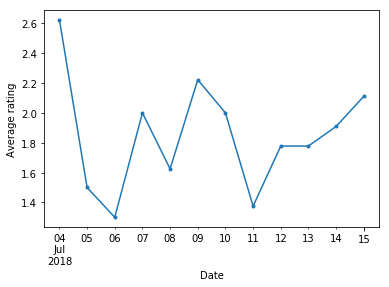

In [154]:
ax = reporter_raw.groupby(pd.Grouper(level=0, freq='1d')).score.mean().plot(marker='.', )
ax.set_xlabel('Date')
ax.set_ylabel('Average rating')
ax.get_figure().savefig('temp.png')